<a href="https://colab.research.google.com/github/OiAb/SpeakerDiarization/blob/main/speakerdiarization_vib3s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations et importations

In [3]:
!pip install -q pyannote.audio==1.1
!pip install pafy
!pip install youtube-dl
!pip install resemblyzer
!pip install pydub
!pip install spectralcluster
!pip install speechbrain
!pip install s4d
!wget -q http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
!wget -q https://raw.githubusercontent.com/pyannote/pyannote-audio/master/tutorials/data_preparation/AMI/MixHeadset.test.rttm

In [2]:
%matplotlib inline
from pyannote.database.util import load_rttm
from resemblyzer import preprocess_wav, VoiceEncoder
from pathlib import Path
import pafy 
import youtube_dl
import torch 
from torch import nn
import torchaudio 
from torchsummary import summary
from torch.utils.data import Dataset,DataLoader
import numpy as numpy
import os, shutil
import subprocess
import tqdm as tqdm
import json
from pyannote.core import Segment, notebook
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd
from pyannote.audio.features import RawAudio
from pyannote.metrics.diarization import DiarizationErrorRate
from pydub import AudioSegment
import argparse
import logging
import matplotlib
import copy
from matplotlib import pyplot as plot
import s4d
from s4d.utils import *
from s4d.diar import Diar
from s4d import viterbi, segmentation
from sidekit import features_server
from s4d.clustering import hac_bic
from sidekit.sidekit_io import init_logging
from s4d.gui.dendrogram import plot_dendrogram
from spectralcluster import SpectralClusterer
import resemblyzer
from resemblyzer.audio import sampling_rate
from speechbrain.pretrained import EncoderDecoderASR
from speechbrain.pretrained import SepformerSeparation as separator
from speechbrain.pretrained import SpeakerRecognition

## AMI annotated data


In [ ]:
DEMO_FILE_AMI = {'uri': 'ES2004a.Mix-Headset', 'audio': '/content/ES2004a.Mix-Headset.wav'}

Visualizing the expected output of the speaker diarization pipeline with pyannote.core.

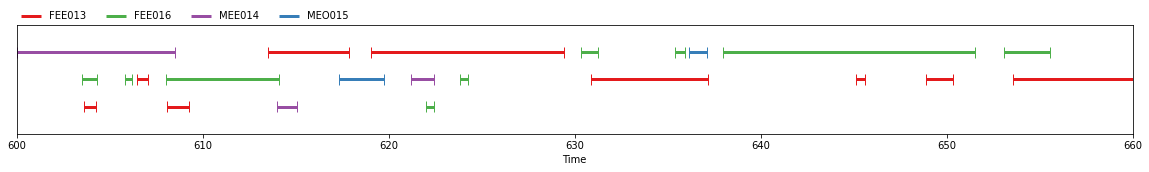

In [ ]:
# load groundtruth
groundtruth = load_rttm('/content/MixHeadset.test.rttm')[DEMO_FILE_AMI['uri']]

# visualize groundtruth
groundtruth

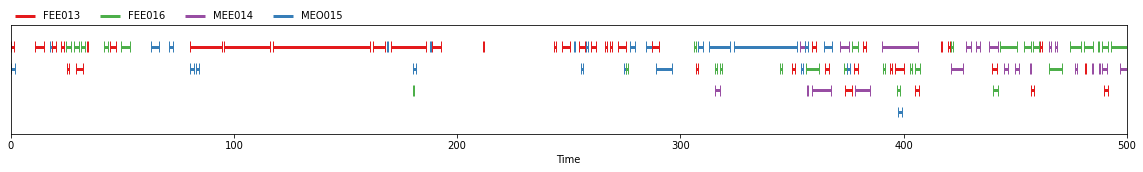

In [ ]:
# make notebook visualization zoom on 600s < t < 660s time range
EXCERPT = Segment(0, 500)
notebook.crop = EXCERPT

# visualize excerpt groundtruth
groundtruth

In [ ]:
waveform, sample_rate = torchaudio.load(DEMO_FILE_AMI['audio'])
print("Stereo signal -> waveform shape: ", waveform.shape)
waveform = torch.mean(waveform, dim=0).unsqueeze(0) # Take only the left channel
print("Mono signal -> waveform shape: ", waveform.shape)
print("Sampling rate: ", sample_rate)

Stereo signal -> waveform shape:  torch.Size([1, 16789675])
Mono signal -> waveform shape:  torch.Size([1, 16789675])
Sampling rate:  16000


In [ ]:
# play the audio 
waveform = RawAudio(sample_rate=16000).crop(DEMO_FILE_AMI, EXCERPT)
Audio(data=waveform.squeeze(), rate=16000, autoplay=True)

## Youtube data

In [ ]:
url = "https://www.youtube.com/watch?v=L69QjJ_2vvk"
video = pafy.new(url)
  
bestaudio = video.getbestaudio()
bestaudio.download()

In [ ]:
# give the file path to your audio file
path = '/content'
for file in os.listdir(path):
    if file.endswith('webm'):
        subprocess.run(['ffmpeg','-i',os.path.join(path,file),'audio.wav'])

In [ ]:
# load audio waveform
wav_fpath = '/content/audio.wav'

waveform, sample_rate = torchaudio.load(wav_fpath)
print("Stereo signal -> waveform shape: ", waveform.shape)
waveform = torch.mean(waveform, dim=0).unsqueeze(0) # Take only the left channel
print("Mono signal -> waveform shape: ", waveform.shape)
print("Sampling rate: ", sample_rate)

Stereo signal -> waveform shape:  torch.Size([2, 39393592])
Mono signal -> waveform shape:  torch.Size([1, 39393592])
Sampling rate:  48000


In [ ]:
# play the audio 
DEMO_FILE_Youtube = {'uri': 'audio', 'audio': wav_fpath}

waveform = RawAudio(sample_rate=16000).crop(DEMO_FILE_Youtube, EXCERPT)
Audio(data=waveform.squeeze(), rate=16000, autoplay=True)

## Podcasts data

In [ ]:
#shutil.rmtree('/content/podcast_part1')
#shutil.rmtree('/content/podcast_part2')

In [6]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [18]:
# Change these paths according to your google drive directories.
audio_data_path1 = "/content/gdrive/MyDrive/podcast_part1.zip"
audio_data_path2 = "/content/gdrive/MyDrive/podcast_part2.zip"

In [19]:
from zipfile import ZipFile

with ZipFile(audio_data_path1, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

with ZipFile(audio_data_path2, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
# Organizing files

path_part1 = '/content/podcast_part1'
path_part2 = '/content/podcast_part2'

for file in os.listdir(path_part1):
    if file.endswith('csv') :
        shutil.move(os.path.join(path_part1, file), path_part2+'/'+file)

for file in os.listdir(path_part2):
    if file.endswith('mp3') or file.endswith('wav') :
        shutil.move(os.path.join(path_part2, file), path_part1+'/'+file)

Deleting files that aren't annotated.

In [ ]:
# Podcast_part1

os.remove("/content/podcast_part1/Reconstruire-le-collectif-face-a-l-incertitude-entre-restauration-et-revolution.mp3")
os.remove("/content/podcast_part1/La_Galere-Tout_plaquer_a_40_ans.mp3")
os.remove("/content/podcast_part1/Basilic-E1_Sabrina_Grosso.wav")
os.remove("/content/podcast_part1/GDIY-206 NICOLAS HENNION_64kbps_stereo.mp3")
os.remove("/content/podcast_part1/GDIY_206_NICOLAS_HENNION_64kbps_mono.mp3")
os.remove("/content/podcast_part1/GDIY_206_NICOLAS_HENNION_96kbps_mono.mp3")
os.remove("/content/podcast_part1/20210219_asc_nmf20210219v3-rx-74f59c50-6fb9-49f4-8baa-b73f28832191.mp3_2513f78bff1a2b1114e176d168977077_64649441.mp3")
os.remove("/content/podcast_part1/En_Aparte-E1_Aller_ou_les_autres_ne_vont_pas.mp3")

# Podcast_part2
os.remove("/content/podcast_part2/En_Aparte-E1_Aller_ou_les_autres_ne_vont_pas.csv")
os.remove("/content/podcast_part2/Amina_Dolbyio.csv")
os.remove("/content/podcast_part2/AVanishing_Point-E1_Pack_your_Stuff.csv")
os.remove("/content/podcast_part2/20210219_asc_nmf20210219v3-rx-74f59c50-6fb9-49f4-8baa-b73f28832191.mp3_2513f78bff1a2b1114e176d168977077_64649441.csv")

In [ ]:
# indexing the files
for i, file in enumerate(os.listdir(path_part1)):
    if file.endswith('mp3') :
        os.rename(os.path.join(path_part1, file), path_part1+ "/{}_{}.{}".format('audio', i, 'mp3'))
    elif file.endswith('wav') :
        os.rename(os.path.join(path_part1, file), path_part1 + "/{}_{}.{}".format('audio', i, 'wav'))

for i, file in enumerate(os.listdir(path_part2)):
  os.rename(os.path.join(path_part2, file), path_part2 + "/{}_{}.{}".format('audio', i, 'csv'))

In [ ]:
def get_audio_path(audio_dir, id):

    tid_str = '{:d}'.format(id)
    file = 'audio_' + tid_str
    file_mp3 = 'audio_' + tid_str + '.mp3'
    if file_mp3 in os.listdir(audio_dir):
      return os.path.join(audio_dir, file + '.mp3')
    else :
      return os.path.join(audio_dir, file +'.wav')

In [ ]:
os.rename(path_part1, "/content/podcast_audio")
os.rename(path_part2, "/content/podcast_csv")

In [ ]:
get_audio_path("/content/podcast_audio", 76)

In [ ]:
path = "/content/podcast_audio"
for file in os.listdir(path):
  if file.endswith('mp3') :
    sound = AudioSegment.from_mp3(os.path.join(path, file))
    sound.export(os.path.splitext(os.path.join(path, file))[0] + '.wav', format="wav")
    os.remove(os.path.join(path, file))

Dataset

In [ ]:
# Create dataset

class AudioDataset(Dataset):
  
  def __init__(self, audio_dir, ids, labels):
    super(AudioDataset,self).__init__()
    self.audio_dir = audio_dir
    self.ids = ids
    self.labels = labels
  
  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    label = self.labels[idx]
    audio_path = get_audio_path(self.audio_dir, self.ids[idx])
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = torch.mean(waveform, dim=0).unsqueeze(0) # Take only the left channel
    transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
    melspectro = transform(waveform)
    
    return melspectro,label


Dataloader

In [ ]:
# Create datasets

"""
y_train = 
y_test =

train_set = AudioDataset(AUDIO_DIR, index_train, y_train)
test_set = AudioDataset(AUDIO_DIR, index_test, y_test)


# Create data loaders
trainloader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)
testloader = DataLoader(test_set, batch_size=8, shuffle=True, num_workers=0)

"""


Testing a file

In [7]:
# load audio waveform
path = "/content/podcast_audio/audio_19.wav"

waveform, sample_rate = torchaudio.load(path)
print("Stereo signal -> waveform shape: ", waveform.shape)
waveform = torch.mean(waveform, dim=0).unsqueeze(0) # Take only the left channel
print("Mono signal -> waveform shape: ", waveform.shape)
print("Sampling rate: ", sample_rate)

Stereo signal -> waveform shape:  torch.Size([1, 52173])
Mono signal -> waveform shape:  torch.Size([1, 52173])
Sampling rate:  16000


In [9]:
# play the audio 
DEMO_FILE_Podcast = {'audio': path}

x, sr = librosa.load(path, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

ipd.Audio(data=x, rate=sr)

Duration: 3.26s, 52173 samples


## Speaker Diarization : Pipeline and evaluation with Pyannote


Running a full speaker diarization pipeline, that includes speech activity detection, speaker change detection, speaker embedding, and a final clustering step

In [ ]:
pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia')
diarization = pipeline(DEMO_FILE_Podcast)

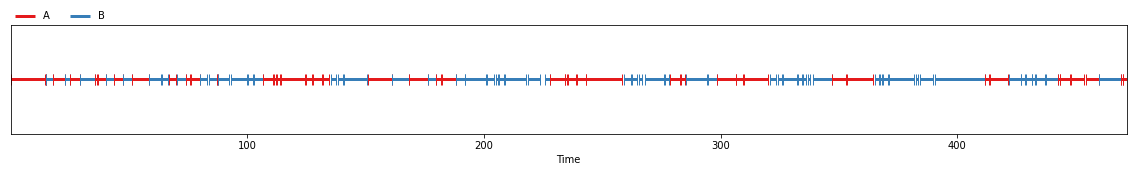

In [ ]:
diarization

In [ ]:
# dump result to disk using RTTM format
with open('/content/Amina.rttm', 'w') as f:
    diarization.write_rttm(f)
  
# iterate over speech turns
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f'Speaker "{speaker}" speaks between t={turn.start:.1f}s and t={turn.end:.1f}s.')

Speaker "A" speaks between t=0.0s and t=14.7s.
Speaker "A" speaks between t=14.9s and t=15.0s.
Speaker "B" speaks between t=15.0s and t=17.9s.
Speaker "A" speaks between t=17.9s and t=22.8s.
Speaker "B" speaks between t=23.2s and t=25.2s.
Speaker "A" speaks between t=25.2s and t=29.5s.
Speaker "B" speaks between t=29.5s and t=35.5s.
Speaker "A" speaks between t=35.5s and t=36.6s.
Speaker "A" speaks between t=36.8s and t=40.4s.
Speaker "B" speaks between t=40.4s and t=43.8s.
Speaker "A" speaks between t=43.8s and t=47.5s.
Speaker "B" speaks between t=47.5s and t=51.1s.
Speaker "A" speaks between t=51.1s and t=58.3s.
Speaker "B" speaks between t=58.3s and t=63.7s.
Speaker "B" speaks between t=64.1s and t=66.7s.
Speaker "A" speaks between t=66.9s and t=69.9s.
Speaker "B" speaks between t=70.1s and t=74.2s.
Speaker "A" speaks between t=74.2s and t=75.9s.
Speaker "A" speaks between t=76.2s and t=79.8s.
Speaker "B" speaks between t=80.0s and t=82.8s.
Speaker "B" speaks between t=83.7s and t=

Evaluation

In [ ]:
metric = DiarizationErrorRate()
der = metric(groundtruth, diarization)
print(f'diarization error rate = {100 * der:.1f}%')

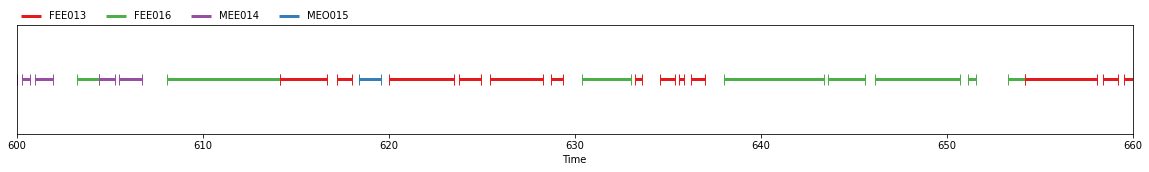

In [ ]:
mapping = metric.optimal_mapping(groundtruth, diarization)
diarization.rename_labels(mapping=mapping)

## Speaker Diarization steps with Pyannote

Speech detection : using a VAD to trim out the silences in the audio file and also normalizes the decibel level of audio.

In [ ]:
wav = preprocess_wav(DEMO_FILE_Podcast['audio'])

Speech segmentation and embedding extraction  : creating an instance of the VoiceEncoder class name encoder, passing cpu as a default device. 

The embed_utterance function of this instance takes in the processed wav file, segments it out into windows , makes MFCCs of these segments and finally creates d-vectors of these audio segments.

The cont_embeds is a N by D matrix, where N is the number of segments created (which is equal to the number of d-vectors) and D is the dimension of each d-vector, which by default is 256. wav_splits is a list with the start and end time of each window for which a d-vector has been created

In [ ]:
encoder = VoiceEncoder("cpu")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
print(cont_embeds.shape)

Loaded the voice encoder model on cpu in 0.05 seconds.
(2420, 256)


Clustering : Spectral clustering works by first creating an affinity matrix of the data ( a matrix whose (i,j)th element is obtained by performing some mathematical operation on ith and jth embedding), and then after performing some matrix operations on this affinity matrix, we use K-means to get the final labels.

In [ ]:
clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=100,
    autotune=None,
    laplacian_type=None,
    refinement_options=None,
    custom_dist="cosine")

labels = clusterer.predict(cont_embeds)

We have got labels for our d-vectors in the previous step. However, each d-vector corresponds to a small window frame, and using them directly for any further task is not feasible. We need to join continuous windows which have a common speaker together.

In [ ]:
def create_labelling(labels,wav_splits):
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    labelling = []
    start_time = 0

    for i,time in enumerate(times):
        if i>0 and labels[i]!=labels[i-1]:
            temp = [str(labels[i-1]),start_time,time]
            labelling.append(tuple(temp))
            start_time = time
        if i==len(times)-1:
            temp = [str(labels[i]),start_time,time]
            labelling.append(tuple(temp))

    return labelling
  
labelling = create_labelling(labels,wav_splits)

In [ ]:
labelling

[('0', 0, 10.82),
 ('1', 10.82, 12.92),
 ('0', 12.92, 15.32),
 ('1', 15.32, 15.38),
 ('0', 15.38, 18.32),
 ('1', 18.32, 18.68),
 ('0', 18.68, 21.8),
 ('1', 21.8, 22.34),
 ('0', 22.34, 22.64),
 ('1', 22.64, 25.82),
 ('0', 25.82, 25.88),
 ('1', 25.88, 26.12),
 ('0', 26.12, 26.84),
 ('1', 26.84, 26.96),
 ('0', 26.96, 27.32),
 ('1', 27.32, 27.62),
 ('0', 27.62, 27.74),
 ('1', 27.74, 27.8),
 ('0', 27.8, 28.58),
 ('1', 28.58, 28.82),
 ('0', 28.82, 29.78),
 ('1', 29.78, 44.06),
 ('0', 44.06, 44.54),
 ('1', 44.54, 45.74),
 ('0', 45.74, 47.0),
 ('1', 47.0, 47.06),
 ('0', 47.06, 47.12),
 ('1', 47.12, 49.7),
 ('0', 49.7, 50.66),
 ('1', 50.66, 53.06),
 ('0', 53.06, 53.12),
 ('1', 53.12, 53.48),
 ('0', 53.48, 53.54),
 ('1', 53.54, 53.6),
 ('0', 53.6, 54.2),
 ('1', 54.2, 55.76),
 ('0', 55.76, 56.24),
 ('1', 56.24, 56.3),
 ('0', 56.3, 56.42),
 ('1', 56.42, 58.4),
 ('0', 58.4, 59.06),
 ('1', 59.06, 59.24),
 ('0', 59.24, 59.42),
 ('1', 59.42, 60.26),
 ('0', 60.26, 60.44),
 ('1', 60.44, 61.22),
 ('0', 6

## Speaker Diarization : Pipeline with Speechbrain

Utilisation d'un modèle de reconnaissance vocale (entraîné sur LibriSpeech) pour transcrire un enregistrement audio.

In [5]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/asr-crdnn-rnnlm-librispeech")
asr_model.transcribe_file('speechbrain/asr-crdnn-rnnlm-librispeech/example.wav')

Downloading:   0%|          | 0.00/104k [00:00<?, ?B/s]

'THE BIRCH CANOE SLID ON THE SMOOTH PLANKS'

Réalisation d'une reconnaissance des locuteurs, pour vérifier si deux enregistrements proviennent des mêmes locuteurs ou de locuteurs différents.

In [12]:
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")
score, prediction = verification.verify_files("speechbrain/spkrec-ecapa-voxceleb/example1.wav", "speechbrain/spkrec-ecapa-voxceleb/example2.flac")

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/104k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

In [13]:
print(score, prediction)

tensor([0.1635]) tensor([False])


Modèles de préentraînement pour la séparation vocale (en utilisant l’architecture SepFormer).

In [3]:
model = separator.from_hparams(source="speechbrain/sepformer-wsj02mix", savedir='pretrained_models/sepformer-wsj02mix')
# for custom file, change path
est_sources = model.separate_file(path='speechbrain/sepformer-wsj02mix/test_mixture.wav')
torchaudio.save("source_1hat.wav", est_sources[:, :, 0].detach().cpu(), 8000)
torchaudio.save("source_2hat.wav", est_sources[:, :, 1].detach().cpu(), 8000)

In [4]:
x, sr = librosa.load("/content/test_mixture.wav", sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

ipd.Audio(data=x, rate=sr)

Duration: 2.07s, 16544 samples


In [5]:
x, sr = librosa.load("/content/source_1hat.wav", sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

ipd.Audio(data=x, rate=sr)

Duration: 2.07s, 16544 samples


In [6]:
x, sr = librosa.load("/content/source_2hat.wav", sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

ipd.Audio(data=x, rate=sr)

Duration: 2.07s, 16544 samples


## Speaker Diarization : Pipeline and evaluation with S4D

In [ ]:
loglevel = logging.INFO
win_size=250
thr_l = 2
thr_h = 3
thr_vit = -250
save_all = True
init_logging( level=loglevel)

In [ ]:
logging.info('Make MFCC')
fs = features_server.FeaturesServer(features_extractor=path,
                                    dct_pca_config='diar_16k')
show = 'id'
logging.info('Load show: %s', show)

root        : INFO     Make MFCC
root        : INFO     Load show: id
